In [1]:
import tensorflow as tf
from keras import backend
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import imageio
import PIL
import time
from IPython import display 
import urllib
import datetime

_______

### Data loading and Preprocessing

This week we have a dataset of little drawn images, in particular drawn images of candles. They come in a normal numpy format, so preprocessing steps are necessary.

In [4]:
category = 'candle'

if not os.path.isdir('/Users/mkalcher01/npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')

print(images.shape)

(141545, 784)


In [5]:
def preprocessing(data):
    """ Data preprocessing """

    # Normalize the data between -1 and 1
    data = (data - 127.5) / 127.5

    # Reshape the data to (batch_size, height, width, channels)
    data = data.reshape(data.shape[0], 28, 28, 1)

    # Convert to tensor
    data = tf.data.Dataset.from_tensor_slices(data)

    # Cast to float32
    data = data.map(lambda x: tf.cast(x, tf.float32))

    # Cache the data
    data = data.cache()

    # Take a subset of the data
    train_data = data.take(50000)

    # Shuffle, batch and prefetch
    train_data = data.shuffle(1000).batch(256).prefetch(25)

    return train_data

In [6]:
train_dataset = preprocessing(images)

________

## Normal GAN

In [77]:
class Generator():
    """ Generator class """
    def __init__(self):
        super(Generator, self).__init__()

        self.model = tf.keras.Sequential()

        # Input random noise
        self.model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.LeakyReLU())

        # Reshape to 2D
        self.model.add(tf.keras.layers.Reshape((7,7,256)))

        # Upsample to 14x14
        self.model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding='same', use_bias=False))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.LeakyReLU())

        # Upsample to 28x28
        self.model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same', use_bias=False))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.LeakyReLU())

        # Output 28x28x1
        self.model.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh'))

    def call(self, inputs):
        return self.model(inputs)

Use the generator to create a first fake image

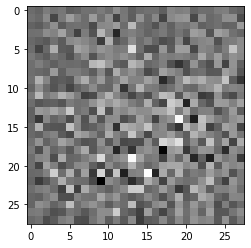

In [6]:
gen  = Generator()

noise = tf.random.normal([1, 100])

generated_image = gen.call(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [7]:
class Discriminator():
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = tf.keras.Sequential()

        # Input 28x28x1 image 
        self.model.add(tf.keras.layers.InputLayer(input_shape=(28, 28, 1)))
        self.model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same'))
        self.model.add(tf.keras.layers.LeakyReLU())
        self.model.add(tf.keras.layers.Dropout(0.3))

        # Downsample to 14x14, increase channels to 128
        self.model.add(tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
        self.model.add(tf.keras.layers.LeakyReLU())
        self.model.add(tf.keras.layers.Dropout(0.3))

        # Downsample to 7x7, increase channels to 256
        self.model.add(tf.keras.layers.Conv2D(256, kernel_size=5, strides=2, padding='same'))
        self.model.add(tf.keras.layers.LeakyReLU())
        self.model.add(tf.keras.layers.Dropout(0.3))

        # Flatten to 1D
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Output a 1 for a real image and a 0 for a generated image

    def call(self, inputs):
        return self.model(inputs)

Use the (untrained) discriminator to classify the fake image as real or fake

In [8]:
discriminator = Discriminator()

decision = discriminator.call(generated_image)

print(decision.numpy())

[[0.5000742]]


Close to 0 = Fake, Close to 1 = Real

Now we define a loss function (cross entropy loss) and an optimizer (Adam).

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

We use two different optimizers: one for the generator and one for the discriminator

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Now we define the training loop

In [25]:
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # Generate images on noise
        generated_images = gen.call(noise)

        # Discriminator decision on real images and generated images
        real_output = discriminator.call(images)
        fake_output = discriminator.call(generated_images)

        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.model.trainable_variables))

    return gen_loss, disc_loss

Function for generating and saving images:

In [20]:
noise_dim = 100
examples_to_generate = 3

random_seed = tf.random.normal([examples_to_generate, noise_dim])

In [27]:
def generate_and_save_images(model, epoch, test_input):

    predictions = model.call(test_input)

    fig = plt.figure(figsize=(7, 5))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 3, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('Users/mkalcher01/GAN/candles/GAN/candle_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Traning loop

In [29]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        gen_losses = []
        disc_losses = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(gen, epoch + 1, random_seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(gen, epochs, random_seed)

    return gen_losses, disc_losses

Training the model

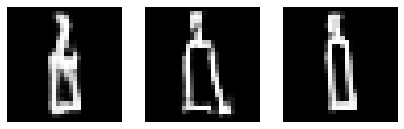

In [30]:
gen_losses, disc_losses = train(train_dataset, 10)

Animate the epochs

In [33]:
animation = 'Users/mkalcher01/GAN/candles/GAN/gan.gif'

with imageio.get_writer(animation, mode='I') as writer:
    filesnames = glob.glob('Users/mkalcher01/GAN/candles/GAN/candle*.png')
    filenames = sorted(filesnames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


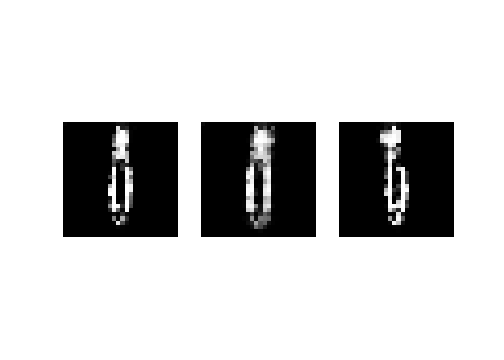

In [34]:
import tensorflow_docs.vis.embed as embed

embed.embed_file('Users/mkalcher01/GAN/candles/GAN/gan.gif')

And finally plot the losses

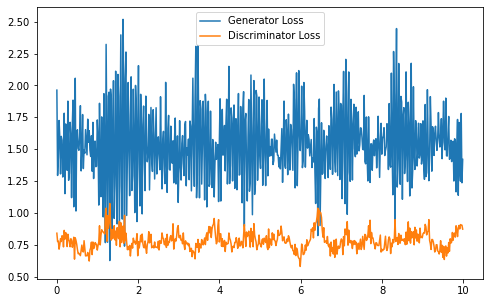

In [46]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(0,10,10/gen_losses.__len__()), [x.numpy() for x in gen_losses], label='Generator Loss')
plt.plot(np.arange(0,10,10/disc_losses.__len__()), [x.numpy() for x in disc_losses], label='Discriminator Loss')
plt.legend()
plt.show()

As we can see, both losses do not converge towards 0, but mostly stay on the same level. This is a good results, since it means that both losses are correctly working against eachother. 

_______


## Wasserstein GAN

The generator stays the same. The discriminator is called a 'critic', which uses a linear activation instead of the sigmoig one. We also use a new Wasserstein loss function and some people seem to use RMSprop instead of Adam, so we did that aswell. 

In [7]:
class WGenerator():
    """ Generator class """
    def __init__(self):
        super(WGenerator, self).__init__()

        self.model = tf.keras.Sequential()

        # Input random noise
        self.model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.LeakyReLU())

        # Reshape to 2D
        self.model.add(tf.keras.layers.Reshape((7,7,256)))

        # Upsample to 14x14
        self.model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding='same', use_bias=False))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.LeakyReLU())

        # Upsample to 28x28
        self.model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same', use_bias=False))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.LeakyReLU())

        # Output 28x28x1
        self.model.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh'))

    def call(self, inputs):
        return self.model(inputs)

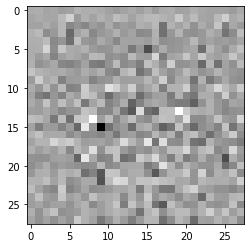

In [8]:
wgen  = WGenerator()

noise = tf.random.normal([1, 100])

generated_image = wgen.call(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

We call this one the 'Critic' instead of a discriminator.

In [9]:
class Critic():
    def __init__(self):
        super(Critic, self).__init__()

        self.model = tf.keras.Sequential()

        # Input 28x28x1 image 
        self.model.add(tf.keras.layers.InputLayer(input_shape=(28, 28, 1)))
        self.model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same'))
        self.model.add(tf.keras.layers.LeakyReLU())
        self.model.add(tf.keras.layers.Dropout(0.3))

        # Downsample to 14x14, increase channels to 128
        self.model.add(tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
        self.model.add(tf.keras.layers.LeakyReLU())
        self.model.add(tf.keras.layers.Dropout(0.3))

        # Downsample to 7x7, increase channels to 256
        self.model.add(tf.keras.layers.Conv2D(256, kernel_size=5, strides=2, padding='same'))
        self.model.add(tf.keras.layers.LeakyReLU())
        self.model.add(tf.keras.layers.Dropout(0.3))

        # Flatten to 1D
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(1, activation='linear'))  # Using linear activation for the critic

    def call(self, inputs):
        return self.model(inputs)

In [10]:
wdiscriminator = Critic()

decision = wdiscriminator.call(generated_image)

print(decision.numpy())

[[-0.00034251]]


Where -1 means guessing the real image and 1 means guessing the fake image.

Now we define a new loss function (cross entropy loss) and use a new optimizer (RMSProp).

In [12]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

In [65]:
def critic_loss(real_output, fake_output):
    return wasserstein_loss(real_output, fake_output) + wasserstein_loss(1 - real_output, 1 - fake_output)

In [71]:
def wgenerator_loss(fake_output):
    return - wasserstein_loss(tf.ones_like(fake_output), fake_output)

In [72]:
wgenerator_optimizer = tf.keras.optimizers.Adam(1e-4)
wdiscriminator_optimizer = tf.keras.optimizers.RMSprop(0.00005)

We use the same train step function as before, but the critic is called more often than before

In [73]:
@tf.function
def wtrain_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # Generate images on noise
        generated_images = wgen.call(noise)

        for _ in range(5):
    
            # Discriminator decision on real images and generated images
            real_output = wdiscriminator.call(images)
            fake_output = wdiscriminator.call(generated_images)

            # Calculate critic loss
            disc_loss = critic_loss(real_output, fake_output)

        # Calculate losses
        gen_loss = wgenerator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, wgen.model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, wdiscriminator.model.trainable_variables)

    wgenerator_optimizer.apply_gradients(zip(gradients_of_generator, wgen.model.trainable_variables))
    wdiscriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, wdiscriminator.model.trainable_variables))

    return gen_loss, disc_loss

And define a new function for generating and saving images (new path)

In [74]:
def new_generate_and_save_images(model, epoch, test_input):

    predictions = model.call(test_input)

    fig = plt.figure(figsize=(7, 5))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 3, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('Users/mkalcher01/GAN/candles/WGAN/candle_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Now we define the a new training loop (where we the critic more often than the discriminator before)

In [75]:
def wtrain(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        gen_losses = []
        disc_losses = []

        for image_batch in dataset:
            gen_loss, disc_loss = wtrain_step(image_batch)
            
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        new_generate_and_save_images(wgen, epoch + 1, random_seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    new_generate_and_save_images(wgen, epochs, random_seed)

    return gen_losses, disc_losses

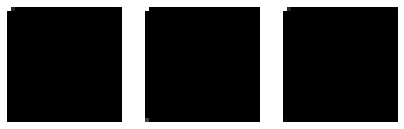

In [76]:
wgen_losses, wdisc_losses = wtrain(train_dataset, 10)

We are unsure why the pictures became like this, and are fine if we do not get an outstanding this week. We just thought that everything else worked fine and thought we would hand it in anyway.

And also plot the results

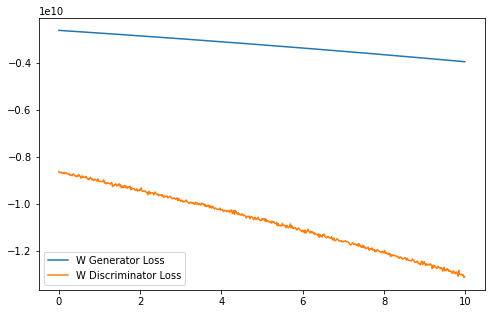

In [109]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(0,10,10/wgen_losses.__len__()), [x.numpy() for x in wgen_losses], label='W Generator Loss')
plt.plot(np.arange(0,10,10/wdisc_losses.__len__()), [x.numpy() for x in wdisc_losses], label='W Discriminator Loss')
plt.legend()
plt.show()

________

## Christmas function

In [80]:
def is_it_christmas(model):
  """
  Christmas function that prints the current number of advent candles burning
  and tells you how many days left till Christmas
  (dependent on current date)

  Parameters:
  ----------
    model : tf.keras.Model
      the (trained) generator
  """
  
  # store the current date
  date = datetime.datetime.now()
  print('Current time is: {}'.format(date))
  month = date.month
  day = date.day

  # example: it is the 20th of December
  month = 12
  day = 20

  # conditions for first advent
  if((month==11 and day>=28) or (month==12 and day<=4)):
   statement = 'Sorry... You have to wait at least 3 weeks to Christmas.'
   advent_number = 1

  # if its not first advent and not December, its not advent
  elif(month!=12):
    return print("It's not even December!")

  # conditions for second, third, fourth advent, month is expected to be December
  elif(day>=5 and day<=11):
    statement = 'Sorry... You have to wait {} more days to Christmas.'.format(24 - day)
    advent_number = 2

  elif(day>=12 and day<=18):
    statement = 'Sorry... You have to wait {} more days to Christmas.'.format(24 - day)
    advent_number = 3

  elif(day>=19 and day<=25):
    statement = 'Sorry... You have to wait {} more days to Christmas.'.format(24 - day)
    advent_number = 4

  else:
    statement = "Sorry, you missed Christmas!"

  print(statement)
  
  # if its advent: show respective number of candles
  if(advent_number >= 1 and advent_number <= 4):
    noise = tf.random.normal([advent_number, 100])

    predictions = model.call(noise)
    fig = plt.figure(figsize=(6, 5))

    for i in range(predictions.shape[0]):
        plt.subplot(1, advent_number, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        plt.show()

  return

Current time is: 2022-01-16 04:29:54.979044
Sorry... You have to wait 4 more days to Christmas.


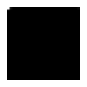

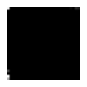

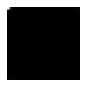

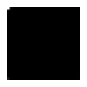

In [81]:
is_it_christmas(wgen)